# Load NBA Season Data

This notebook loads data from nba_season_results.xlsx


In [55]:
import pandas as pd
import os
from pathlib import Path

# Get the data file path
project_root = Path().resolve().parent
data_file = project_root / 'data' / 'results' / 'nba_season_results.xlsx'

# Load the data
df = pd.read_excel(data_file)

# Display basic info
print(f"Loaded {len(df)} games")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Loaded 450 games

Columns: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']

First few rows:


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-10-21,Oklahoma City Thunder,Houston Rockets,-6.5,125,124,-5.5
1,2025-10-21,Los Angeles Lakers,Golden State Warriors,2.5,109,119,-7.5
2,2025-10-22,Orlando Magic,Miami Heat,-8.5,125,121,-4.5
3,2025-10-22,Atlanta Hawks,Toronto Raptors,-5.5,118,138,-25.5
4,2025-10-22,Chicago Bulls,Detroit Pistons,3.5,115,111,7.5


## Team Spread Coverage Analysis

Analyze how well each team covers their closing spreads.


In [56]:
# Prepare data for team analysis
# We need to determine if each team covered in each game

# Create a copy for analysis
analysis_df = df.copy()

# Ensure we have the necessary columns
print("Columns available:", list(analysis_df.columns))
print(f"\nTotal games: {len(analysis_df)}")
print(f"Games with scores: {analysis_df[['home_score', 'away_score']].notna().all(axis=1).sum()}")
print(f"Games with spreads: {analysis_df['closing_spread'].notna().sum()}")


Columns available: ['game_date', 'home_team', 'away_team', 'closing_spread', 'home_score', 'away_score', 'spread_result_difference']

Total games: 450
Games with scores: 450
Games with spreads: 450


In [57]:
# Calculate spread coverage for each team in each game
# The closing_spread is from the home team's perspective
# Positive spread_result_difference means home team covered

# Filter to games with both scores and spreads
games_with_data = analysis_df[
    analysis_df[['home_score', 'away_score']].notna().all(axis=1) & 
    analysis_df['closing_spread'].notna()
].copy()

print(f"Games with complete data (scores + spreads): {len(games_with_data)}")

# Determine if home team covered
# spread_result_difference = (home_score - away_score) + closing_spread
# If > 0: home team covered, if < 0: home team didn't cover, if = 0: push
games_with_data['home_covered'] = games_with_data['spread_result_difference'] > 0
games_with_data['away_covered'] = games_with_data['spread_result_difference'] < 0
games_with_data['push'] = games_with_data['spread_result_difference'] == 0

print(f"\nHome team covers: {games_with_data['home_covered'].sum()}")
print(f"Away team covers: {games_with_data['away_covered'].sum()}")
print(f"Pushes: {games_with_data['push'].sum()}")


Games with complete data (scores + spreads): 450

Home team covers: 227
Away team covers: 220
Pushes: 3


In [58]:
# Create records for each team's performance in each game
team_records = []

for idx, row in games_with_data.iterrows():
    # Home team record
    team_records.append({
        'team': row['home_team'],
        'opponent': row['away_team'],
        'game_date': row['game_date'],
        'was_home': True,
        'spread': row['closing_spread'],
        'covered': row['home_covered'],
        'push': row['push'],
        'score_for': row['home_score'],
        'score_against': row['away_score'],
        'spread_result_difference': row['spread_result_difference']
    })
    
    # Away team record
    team_records.append({
        'team': row['away_team'],
        'opponent': row['home_team'],
        'game_date': row['game_date'],
        'was_home': False,
        'spread': -row['closing_spread'],  # Flip the spread for away team
        'covered': row['away_covered'],
        'push': row['push'],
        'score_for': row['away_score'],
        'score_against': row['home_score'],
        'spread_result_difference': -row['spread_result_difference']  # Flip for away team
    })

team_df = pd.DataFrame(team_records)
print(f"Total team-game records: {len(team_df)}")
print(f"Unique teams: {team_df['team'].nunique()}")
team_df.head()


Total team-game records: 900
Unique teams: 30


,team,opponent,game_date,was_home,spread,covered,push,score_for,score_against,spread_result_difference
0,Oklahoma City Thunder,Houston Rockets,2025-10-21,True,-6.5,False,False,125,124,-5.5
1,Houston Rockets,Oklahoma City Thunder,2025-10-21,False,6.5,True,False,124,125,5.5
2,Los Angeles Lakers,Golden State Warriors,2025-10-21,True,2.5,False,False,109,119,-7.5
3,Golden State Warriors,Los Angeles Lakers,2025-10-21,False,-2.5,True,False,119,109,7.5
4,Orlando Magic,Miami Heat,2025-10-22,True,-8.5,False,False,125,121,-4.5


In [59]:
# Calculate team spread coverage statistics
team_stats = team_df.groupby('team').agg({
    'covered': ['sum', 'count'],
    'push': 'sum'
}).reset_index()

team_stats.columns = ['team', 'covers', 'total_games', 'pushes']
team_stats['non_push_games'] = team_stats['total_games'] - team_stats['pushes']
team_stats['cover_pct'] = (team_stats['covers'] / team_stats['non_push_games'] * 100).round(2)
team_stats['non_cover'] = team_stats['non_push_games'] - team_stats['covers']

# Sort by cover percentage
team_stats = team_stats.sort_values('cover_pct', ascending=False).reset_index(drop=True)

print("Team Spread Coverage Statistics:")
print("="*80)
team_stats


Team Spread Coverage Statistics:


,team,covers,total_games,pushes,non_push_games,cover_pct,non_cover
0,Phoenix Suns,19,29,1,28,67.86,9
1,Philadelphia 76ers,17,28,1,27,62.96,10
2,San Antonio Spurs,20,32,0,32,62.50,12
3,New Orleans Pelicans,19,31,0,31,61.29,12
4,Denver Nuggets,18,30,0,30,60.00,12
5,Utah Jazz,17,29,0,29,58.62,12
6,New York Knicks,18,31,0,31,58.06,13
7,Houston Rockets,16,28,0,28,57.14,12
8,Detroit Pistons,17,30,0,30,56.67,13
9,Boston Celtics,16,29,0,29,55.17,13


## Detailed Coverage Analysis: Coverage Percentage and Cover Margin

Analyze how often teams cover their closing spreads AND by how many points they cover when they do cover.

Key Metrics:
- **Coverage Percentage**: How often a team covers the spread
- **Average Cover Margin**: When a team DOES cover, by how many points on average (e.g., if spread was -10 and they won by 25, they covered by 15 points)
- **Distribution**: How the cover margins are distributed


In [60]:
# Detailed Coverage Analysis: Calculate both coverage % and average cover margin

# Create team-level analysis for both home and away games
team_detailed_stats = []

for team in team_df['team'].unique():
    team_games = team_df[team_df['team'] == team].copy()
    
    total_games = len(team_games)
    covers = team_games['covered'].sum()
    non_covers = total_games - covers
    pushes = team_games['push'].sum()
    non_push_games = total_games - pushes
    
    # Calculate coverage percentage (excluding pushes)
    if non_push_games > 0:
        cover_pct = (covers / non_push_games) * 100
    else:
        cover_pct = 0
    
    # Calculate average cover margin (only when they covered, only positive values)
    cover_margins = team_games[team_games['covered'] == True]['spread_result_difference'].values
    avg_cover_margin = cover_margins.mean() if len(cover_margins) > 0 else 0
    
    # Additional stats
    max_cover_margin = cover_margins.max() if len(cover_margins) > 0 else 0
    min_cover_margin = cover_margins.min() if len(cover_margins) > 0 else 0
    
    # Calculate average failure margin (when they didn't cover, negative values)
    failure_margins = team_games[team_games['covered'] == False]['spread_result_difference'].values
    avg_failure_margin = failure_margins.mean() if len(failure_margins) > 0 else 0
    
    team_detailed_stats.append({
        'team': team,
        'total_games': total_games,
        'covers': covers,
        'non_covers': non_covers,
        'pushes': pushes,
        'non_push_games': non_push_games,
        'cover_pct': round(cover_pct, 2),
        'avg_cover_margin': round(avg_cover_margin, 2),  # Average points covered by when covering
        'max_cover_margin': round(max_cover_margin, 2),
        'min_cover_margin': round(min_cover_margin, 2),
        'avg_failure_margin': round(avg_failure_margin, 2)  # Average points failed by when not covering
    })

team_detailed_df = pd.DataFrame(team_detailed_stats)
team_detailed_df = team_detailed_df.sort_values('cover_pct', ascending=False).reset_index(drop=True)

print("="*100)
print("TEAM COVERAGE ANALYSIS: Coverage Percentage & Cover Margin")
print("="*100)
print(f"\n{'Team':<25} {'Cover%':<8} {'Avg Cover':<12} {'Max Cover':<12} {'Games':<8} {'Covers':<8}")
print("-"*100)
for _, row in team_detailed_df.iterrows():
    print(f"{row['team']:<25} {row['cover_pct']:>6.1f}%  {row['avg_cover_margin']:>10.2f}  {row['max_cover_margin']:>10.2f}  {row['total_games']:>6}  {row['covers']:>6}")

print(f"\n{'='*100}")
print("Summary Statistics:")
print(f"  Average Coverage %: {team_detailed_df['cover_pct'].mean():.2f}%")
print(f"  Average Cover Margin (when covering): {team_detailed_df[team_detailed_df['covers'] > 0]['avg_cover_margin'].mean():.2f} points")
print(f"  Teams with >50% coverage: {(team_detailed_df['cover_pct'] > 50).sum()}")
print(f"{'='*100}\n")

team_detailed_df


TEAM COVERAGE ANALYSIS: Coverage Percentage & Cover Margin

Team                      Cover%   Avg Cover    Max Cover    Games    Covers  
----------------------------------------------------------------------------------------------------
Phoenix Suns                67.9%       11.92       31.50      29      19
Philadelphia 76ers          63.0%        6.79       19.50      28      17
San Antonio Spurs           62.5%       12.18       37.50      32      20
New Orleans Pelicans        61.3%        7.82       27.50      31      19
Denver Nuggets              60.0%        9.00       22.50      30      18
Utah Jazz                   58.6%       10.09       31.50      29      17
New York Knicks             58.1%        8.78       21.50      31      18
Houston Rockets             57.1%       12.06       23.00      28      16
Detroit Pistons             56.7%        8.47       20.50      30      17
Los Angeles Lakers          55.2%        7.62       25.50      29      16
Boston Celtics      

,team,total_games,covers,non_covers,pushes,non_push_games,cover_pct,avg_cover_margin,max_cover_margin,min_cover_margin,avg_failure_margin
0,Phoenix Suns,29,19,10,1,28,67.86,11.92,31.5,0.5,-10.95
1,Philadelphia 76ers,28,17,11,1,27,62.96,6.79,19.5,0.5,-8.32
2,San Antonio Spurs,32,20,12,0,32,62.50,12.18,37.5,0.5,-6.88
3,New Orleans Pelicans,31,19,12,0,31,61.29,7.82,27.5,0.5,-11.17
4,Denver Nuggets,30,18,12,0,30,60.00,9.00,22.5,0.5,-9.33
5,Utah Jazz,29,17,12,0,29,58.62,10.09,31.5,0.5,-12.83
6,New York Knicks,31,18,13,0,31,58.06,8.78,21.5,0.5,-8.35
7,Houston Rockets,28,16,12,0,28,57.14,12.06,23.0,3.0,-12.17
8,Detroit Pistons,30,17,13,0,30,56.67,8.47,20.5,1.5,-6.31
9,Los Angeles Lakers,29,16,13,0,29,55.17,7.62,25.5,0.5,-14.69


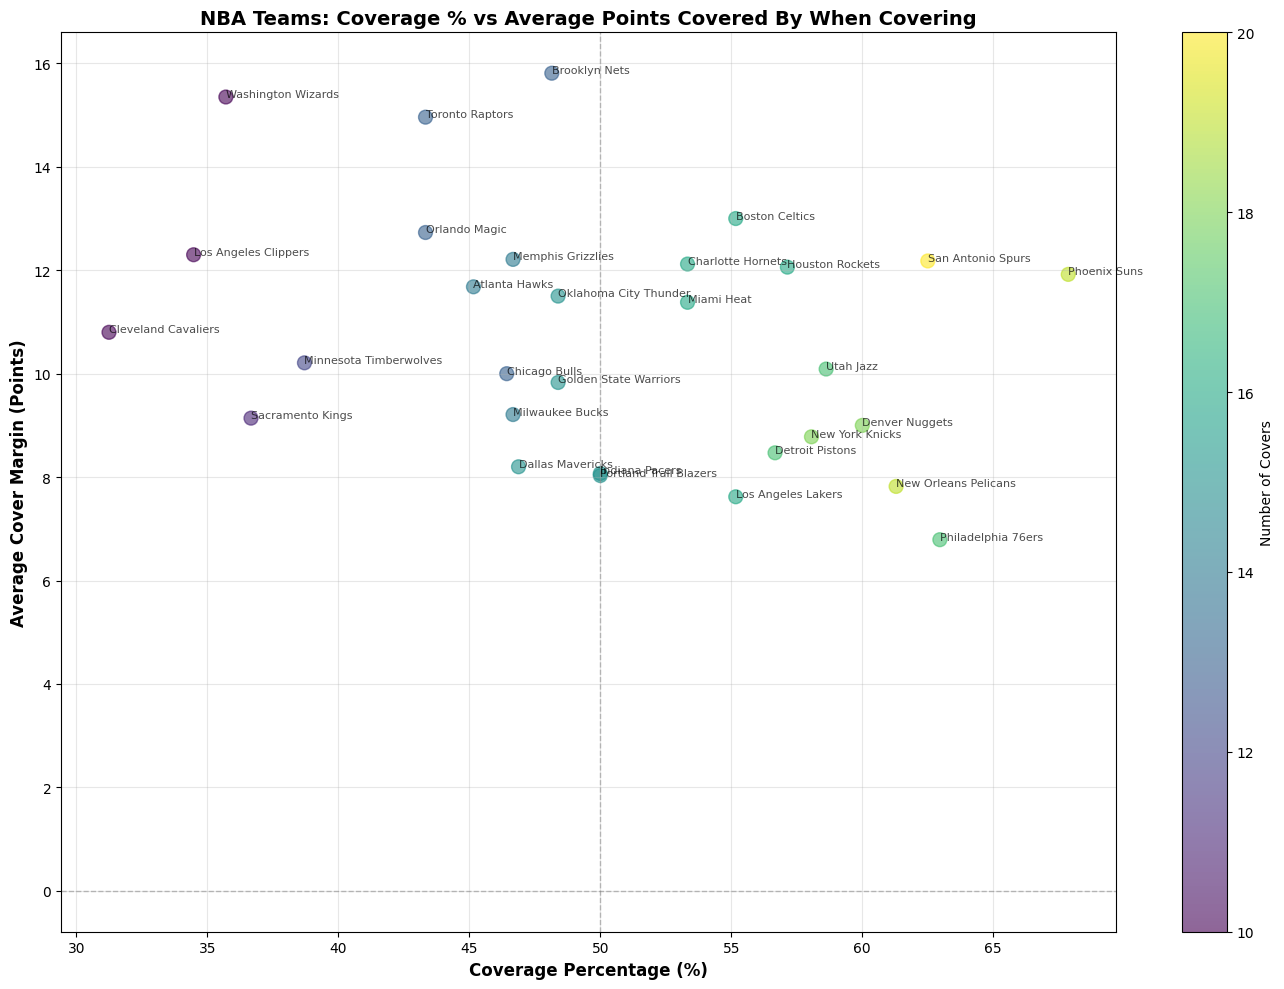


Top 10 Teams by Coverage Percentage:
                   team  cover_pct  avg_cover_margin  covers  total_games
0          Phoenix Suns      67.86             11.92      19           29
1    Philadelphia 76ers      62.96              6.79      17           28
2     San Antonio Spurs      62.50             12.18      20           32
3  New Orleans Pelicans      61.29              7.82      19           31
4        Denver Nuggets      60.00              9.00      18           30
5             Utah Jazz      58.62             10.09      17           29
6       New York Knicks      58.06              8.78      18           31
7       Houston Rockets      57.14             12.06      16           28
8       Detroit Pistons      56.67              8.47      17           30
9    Los Angeles Lakers      55.17              7.62      16           29


Top 10 Teams by Average Cover Margin (when covering):
                    team  avg_cover_margin  cover_pct  covers
17         Brooklyn Nets      

In [ ]:
# Visualize Coverage Percentage vs Average Cover Margin
plt.figure(figsize=(14, 10))
scatter = plt.scatter(team_detailed_df['cover_pct'], team_detailed_df['avg_cover_margin'], 
                     s=100, alpha=0.6, c=team_detailed_df['covers'], cmap='viridis')
plt.xlabel('Coverage Percentage (%)', fontsize=12, fontweight='bold')
plt.ylabel('Average Cover Margin (Points)', fontsize=12, fontweight='bold')
plt.title('NBA Teams: Coverage % vs Average Points Covered By When Covering', fontsize=14, fontweight='bold')
plt.axvline(x=50, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(alpha=0.3)

# Add team labels for outliers or top performers
for _, row in team_detailed_df.iterrows():
    if row['cover_pct'] > 55 or row['avg_cover_margin'] > 8:
        plt.annotate(row['team'], (row['cover_pct'], row['avg_cover_margin']), 
                    fontsize=8, alpha=0.7)

plt.colorbar(scatter, label='Number of Covers')
plt.tight_layout()
plt.show()

print("\nTop 10 Teams by Coverage Percentage:")
print(team_detailed_df.head(10)[['team', 'cover_pct', 'avg_cover_margin', 'covers', 'total_games']])
print("\n\nTop 10 Teams by Average Cover Margin (when covering):")
print(team_detailed_df[team_detailed_df['covers'] > 0].nlargest(10, 'avg_cover_margin')[['team', 'avg_cover_margin', 'cover_pct', 'covers']])


## Interactive Team Game Results Search

Search for any team to see their game-by-game results, closing spreads, and coverage performance.


In [ ]:
# Interactive widget to search for a team and view their game results
import ipywidgets as widgets
from IPython.display import display, HTML
from ipywidgets import interact

# Get unique teams sorted alphabetically
all_teams = sorted(team_df['team'].unique())

def display_team_games(team_name):
    """Display game-by-game results for selected team"""
    # Filter games for this team
    team_games = team_df[team_df['team'] == team_name].copy()
    team_games = team_games.sort_values('game_date', ascending=False).reset_index(drop=True)
    
    if len(team_games) == 0:
        print(f"No games found for {team_name}")
        return
    
    # Prepare display columns
    display_df = team_games[['game_date', 'opponent', 'was_home', 'spread', 
                            'score_for', 'score_against', 'covered', 'spread_result_difference']].copy()
    
    # Format columns
    display_df['game_date'] = pd.to_datetime(display_df['game_date']).dt.strftime('%Y-%m-%d')
    display_df['location'] = display_df['was_home'].map({True: 'Home', False: 'Away'})
    display_df['spread_formatted'] = display_df['spread'].apply(lambda x: f"{x:+.1f}" if pd.notna(x) else "N/A")
    display_df['score'] = display_df.apply(lambda row: f"{int(row['score_for'])}-{int(row['score_against'])}", axis=1)
    display_df['result'] = display_df.apply(lambda row: "W" if row['score_for'] > row['score_against'] else "L", axis=1)
    display_df['covered_status'] = display_df.apply(
        lambda row: "✓ Cover" if row['covered'] else ("Push" if row['spread_result_difference'] == 0 else "✗ No Cover"),
        axis=1
    )
    display_df['margin'] = display_df['spread_result_difference'].apply(
        lambda x: f"{x:+.2f}" if pd.notna(x) else "N/A"
    )
    
    # Select and rename columns for display
    display_columns = display_df[['game_date', 'location', 'opponent', 'result', 'score', 
                                 'spread_formatted', 'covered_status', 'margin']].copy()
    display_columns.columns = ['Date', 'H/A', 'Opponent', 'Result', 'Score', 
                              'Closing Spread', 'Covered?', 'Margin']
    
    # Add summary stats
    total_games = len(team_games)
    covers = team_games['covered'].sum()
    non_covers = total_games - team_games['push'].sum() - covers
    pushes = team_games['push'].sum()
    cover_pct = (covers / (total_games - pushes) * 100) if (total_games - pushes) > 0 else 0
    
    print("="*100)
    print(f"GAME-BY-GAME RESULTS: {team_name.upper()}")
    print("="*100)
    print(f"\nSummary: {covers} covers, {non_covers} non-covers, {pushes} pushes")
    print(f"Coverage Percentage: {cover_pct:.2f}%")
    print(f"Total Games: {total_games}")
    print("\n")
    
    # Color-code margin column before display
    def color_margin(val):
        if val == 'N/A':
            return 'color: black'
        try:
            margin_val = float(val.replace('+', ''))
            if margin_val > 0:
                return 'color: green; font-weight: bold'
            elif margin_val < 0:
                return 'color: red; font-weight: bold'
            else:
                return 'color: black'
        except:
            return 'color: black'
    
    # Display table with styling
    styled_table = display_columns.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), 
                                   ('font-weight', 'bold'), ('padding', '8px')]},
        {'selector': 'td', 'props': [('padding', '6px')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f5f5f5')]},
    ]).applymap(color_margin, subset=['Margin'])
    
    display(styled_table)
    
    print("\n" + "="*100)
    print("Legend:")
    print("  H/A: Home or Away")
    print("  Result: W = Win, L = Loss")
    print("  Closing Spread: From team's perspective (+ means favored, - means underdog)")
    print("  Margin: Points covered by (+) or failed by (-)")
    print("="*100)

# Create interactive widget using interact with Combobox (searchable dropdown)
print("🔍 Search Team Game Results")
print("="*100)
print("Type to search or select from dropdown\n")

interact(display_team_games, 
         team_name=widgets.Combobox(
             options=all_teams,
             value=all_teams[0] if len(all_teams) > 0 else '',
             placeholder='Type team name or select from dropdown',
             description='Team:',
             style={'description_width': 'initial'},
             layout=widgets.Layout(width='400px'),
             ensure_option=True
         ))


🔍 Search Team Game Results
Type to search and press Enter or select from dropdown



## Team Coverage Trends Over Time

Track how each team's coverage percentage, average cover margin, and average failure margin change over the course of the season.


In [63]:
# Prepare data for time-based team analysis
# Sort by date to ensure proper cumulative calculations
team_df_sorted = team_df.sort_values('game_date').copy()
team_df_sorted['game_date'] = pd.to_datetime(team_df_sorted['game_date'])

# Get unique dates
unique_dates = sorted(team_df_sorted['game_date'].unique())

print(f"Season spans from {unique_dates[0].date()} to {unique_dates[-1].date()}")
print(f"Total unique game dates: {len(unique_dates)}")
print(f"Total teams: {team_df_sorted['team'].nunique()}")


Season spans from 2025-10-21 to 2025-12-25
Total unique game dates: 64
Total teams: 30


In [64]:
# Calculate cumulative statistics for each team over time
team_time_stats = []

all_teams_list = sorted(team_df_sorted['team'].unique())

for team in all_teams_list:
    team_games = team_df_sorted[team_df_sorted['team'] == team].copy()
    
    for date_idx, current_date in enumerate(unique_dates):
        # Get all games up to and including current_date (cumulative)
        cumulative_games = team_games[team_games['game_date'] <= current_date]
        
        if len(cumulative_games) == 0:
            continue
        
        # Calculate coverage statistics
        covers = cumulative_games['covered'].sum()
        non_covers = len(cumulative_games) - cumulative_games['push'].sum() - covers
        pushes = cumulative_games['push'].sum()
        total_games = len(cumulative_games)
        non_push_games = total_games - pushes
        
        # Coverage percentage (excluding pushes)
        cover_pct = (covers / non_push_games * 100) if non_push_games > 0 else 0
        
        # Average points over coverage (when they covered)
        cover_margins = cumulative_games[cumulative_games['covered']]['spread_result_difference']
        avg_cover_margin = cover_margins.mean() if len(cover_margins) > 0 else 0
        
        # Average points under coverage (when they didn't cover, excluding pushes)
        non_cover_margins = cumulative_games[
            (~cumulative_games['covered']) & (~cumulative_games['push'])
        ]['spread_result_difference']
        avg_failure_margin = non_cover_margins.mean() if len(non_cover_margins) > 0 else 0
        
        team_time_stats.append({
            'team': team,
            'date': current_date,
            'days_into_season': date_idx + 1,
            'total_games': total_games,
            'covers': covers,
            'non_covers': non_covers,
            'pushes': pushes,
            'cover_pct': cover_pct,
            'avg_cover_margin': avg_cover_margin,
            'avg_failure_margin': avg_failure_margin
        })

team_time_df = pd.DataFrame(team_time_stats)
print(f"Calculated time-based statistics for {len(all_teams_list)} teams")
print(f"Total data points: {len(team_time_df)}")
team_time_df.head(10)


Calculated time-based statistics for 30 teams
Total data points: 1892


,team,date,days_into_season,total_games,covers,non_covers,pushes,cover_pct,avg_cover_margin,avg_failure_margin
0,Atlanta Hawks,2025-10-22,2,1,0,1,0,0.000000,0.0,-25.500000
1,Atlanta Hawks,2025-10-23,3,1,0,1,0,0.000000,0.0,-25.500000
2,Atlanta Hawks,2025-10-24,4,2,1,1,0,50.000000,9.5,-25.500000
3,Atlanta Hawks,2025-10-25,5,3,1,2,0,33.333333,9.5,-17.000000
4,Atlanta Hawks,2025-10-26,6,3,1,2,0,33.333333,9.5,-17.000000
5,Atlanta Hawks,2025-10-27,7,4,1,3,0,25.000000,9.5,-13.833333
6,Atlanta Hawks,2025-10-28,8,4,1,3,0,25.000000,9.5,-13.833333
7,Atlanta Hawks,2025-10-29,9,5,1,4,0,20.000000,9.5,-11.250000
8,Atlanta Hawks,2025-10-30,10,5,1,4,0,20.000000,9.5,-11.250000
9,Atlanta Hawks,2025-10-31,11,6,2,4,0,33.333333,13.5,-11.250000


In [65]:
# Interactive widget to visualize team coverage trends over time
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np

def plot_team_trends(team_name):
    """Plot coverage trends over time for selected team"""
    team_data = team_time_df[team_time_df['team'] == team_name].copy()
    team_data = team_data.sort_values('date')
    
    if len(team_data) == 0:
        print(f"No data found for {team_name}")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot 1: Coverage Percentage Over Time
    ax1 = axes[0]
    ax1.plot(team_data['days_into_season'], team_data['cover_pct'], 
             marker='o', linewidth=2, markersize=4, color='blue', label='Coverage %')
    ax1.axhline(y=50, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='50% (Break Even)')
    ax1.set_xlabel('Days into Season', fontsize=11)
    ax1.set_ylabel('Coverage Percentage (%)', fontsize=11)
    ax1.set_title(f'{team_name} - Coverage Percentage Over Time', fontsize=13, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_ylim([0, 100])
    
    # Plot 2: Average Cover Margin Over Time
    ax2 = axes[1]
    cover_data = team_data[team_data['covers'] > 0].copy()
    if len(cover_data) > 0:
        ax2.plot(cover_data['days_into_season'], cover_data['avg_cover_margin'], 
                marker='s', linewidth=2, markersize=4, color='green', label='Avg Points Over Cover')
        ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Days into Season', fontsize=11)
    ax2.set_ylabel('Average Points Over Cover', fontsize=11)
    ax2.set_title(f'{team_name} - Average Points Over Coverage When Covering', fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Average Failure Margin Over Time
    ax3 = axes[2]
    failure_data = team_data[team_data['non_covers'] > 0].copy()
    if len(failure_data) > 0:
        ax3.plot(failure_data['days_into_season'], failure_data['avg_failure_margin'], 
                marker='^', linewidth=2, markersize=4, color='red', label='Avg Points Under Cover')
        ax3.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax3.set_xlabel('Days into Season', fontsize=11)
    ax3.set_ylabel('Average Points Under Cover', fontsize=11)
    ax3.set_title(f'{team_name} - Average Points Under Coverage When Not Covering', fontsize=13, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    latest_stats = team_data.iloc[-1]
    print(f"\n{'='*100}")
    print(f"LATEST STATISTICS FOR {team_name.upper()}")
    print(f"{'='*100}")
    print(f"Total Games: {latest_stats['total_games']}")
    print(f"Covers: {latest_stats['covers']} ({latest_stats['cover_pct']:.2f}%)")
    print(f"Non-Covers: {latest_stats['non_covers']}")
    print(f"Pushes: {latest_stats['pushes']}")
    print(f"Average Points Over Cover: {latest_stats['avg_cover_margin']:.2f}")
    print(f"Average Points Under Cover: {latest_stats['avg_failure_margin']:.2f}")
    print(f"{'='*100}\n")

print("🔍 Select Team to View Coverage Trends Over Time")
print("="*100)
print("Use the dropdown below to select a team and view their coverage trends\n")

interact(plot_team_trends, 
         team_name=widgets.Combobox(
             options=all_teams_list,
             value=all_teams_list[0] if len(all_teams_list) > 0 else '',
             placeholder='Type team name or select from dropdown',
             description='Team:',
             style={'description_width': 'initial'},
             layout=widgets.Layout(width='400px'),
             ensure_option=True
         ))


🔍 Select Team to View Coverage Trends Over Time
Use the dropdown below to select a team and view their coverage trends



interactive(children=(Combobox(value='Atlanta Hawks', description='Team:', ensure_option=True, layout=Layout(w…

<function __main__.plot_team_trends(team_name)>

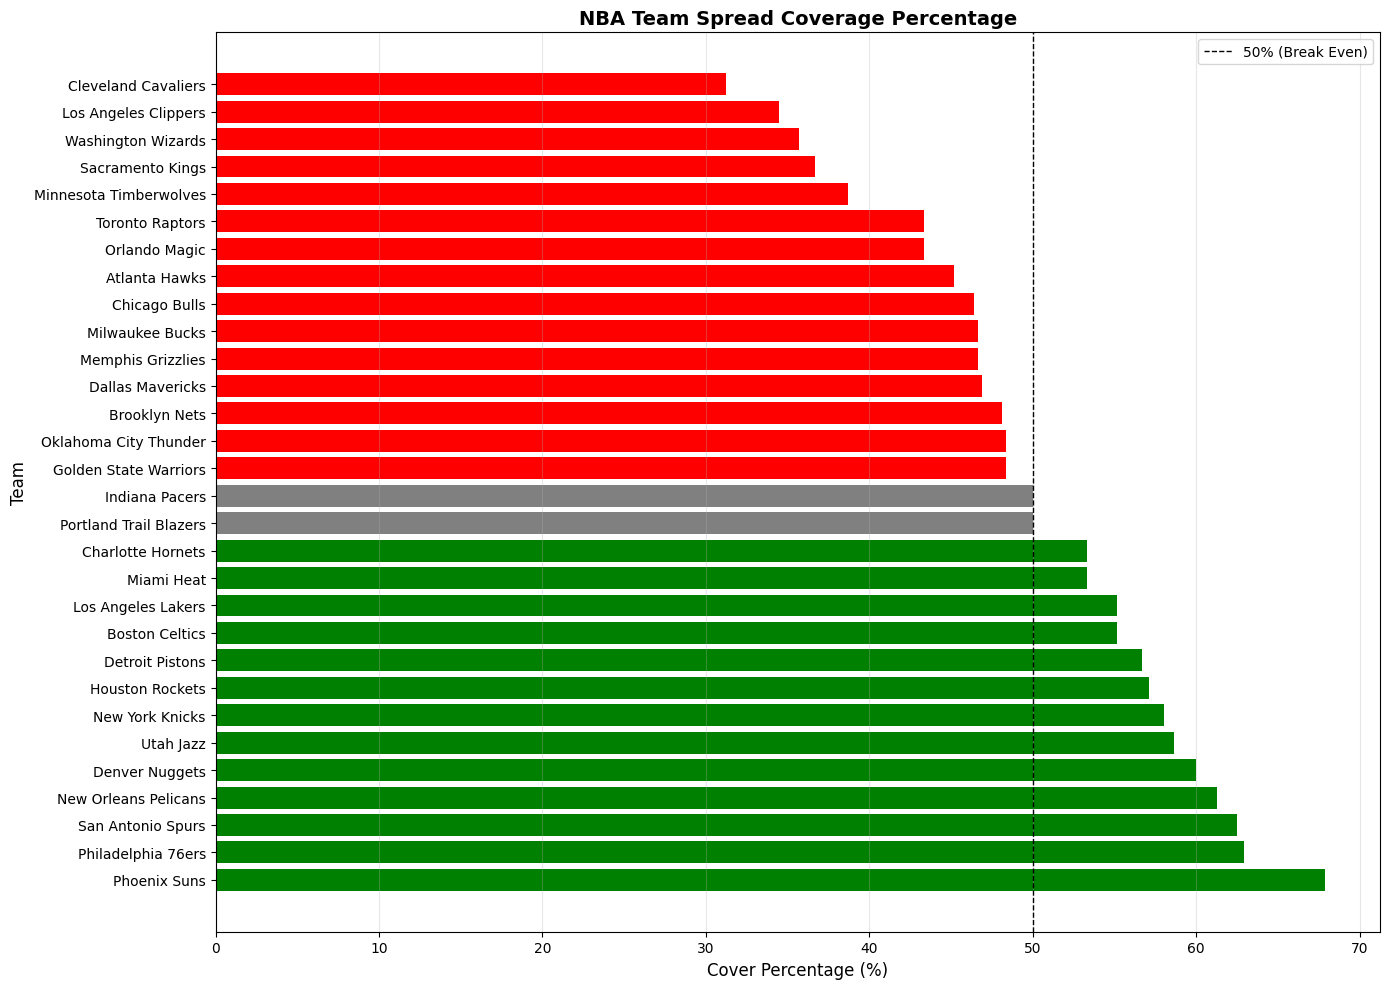


Best covering teams (top 5):
                   team  covers  non_cover  cover_pct
0          Phoenix Suns      19          9      67.86
1    Philadelphia 76ers      17         10      62.96
2     San Antonio Spurs      20         12      62.50
3  New Orleans Pelicans      19         12      61.29
4        Denver Nuggets      18         12      60.00

Worst covering teams (bottom 5):
                      team  covers  non_cover  cover_pct
25  Minnesota Timberwolves      12         19      38.71
26        Sacramento Kings      11         19      36.67
27      Washington Wizards      10         18      35.71
28    Los Angeles Clippers      10         19      34.48
29     Cleveland Cavaliers      10         22      31.25


In [66]:
# Visualize team cover percentages
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
bars = plt.barh(range(len(team_stats)), team_stats['cover_pct'], 
                color=['green' if x > 50 else 'red' if x < 50 else 'gray' for x in team_stats['cover_pct']])
plt.yticks(range(len(team_stats)), team_stats['team'])
plt.xlabel('Cover Percentage (%)', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('NBA Team Spread Coverage Percentage', fontsize=14, fontweight='bold')
plt.axvline(x=50, color='black', linestyle='--', linewidth=1, label='50% (Break Even)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest covering teams (top 5):")
print(team_stats.head(5)[['team', 'covers', 'non_cover', 'cover_pct']])
print(f"\nWorst covering teams (bottom 5):")
print(team_stats.tail(5)[['team', 'covers', 'non_cover', 'cover_pct']])


## Failed to Cover by 11+ Points Analysis

Analyze how often teams fail to cover their spread by 11 or more points.


In [67]:
# Calculate how often teams fail to cover by 11+ points
# spread_result_difference < -11 means they didn't cover by more than 11 points

team_df['failed_by_11_plus'] = team_df['spread_result_difference'] < -11

print("Failed to Cover by 11+ Points Analysis:")
print("="*60)
print(f"Total team-game records: {len(team_df)}")
print(f"Games where team failed to cover by 11+: {team_df['failed_by_11_plus'].sum()}")
print(f"Percentage: {team_df['failed_by_11_plus'].sum() / len(team_df) * 100:.2f}%")


Failed to Cover by 11+ Points Analysis:
Total team-game records: 900
Games where team failed to cover by 11+: 169
Percentage: 18.78%


In [68]:
# Calculate per-team statistics for failing to cover by 11+
team_fail_11_stats = team_df.groupby('team').agg({
    'failed_by_11_plus': ['sum', 'count']
}).reset_index()

team_fail_11_stats.columns = ['team', 'failed_by_11_plus_count', 'total_games']
team_fail_11_stats['failed_by_11_plus_pct'] = (team_fail_11_stats['failed_by_11_plus_count'] / 
                                                team_fail_11_stats['total_games'] * 100).round(2)

# Sort by frequency
team_fail_11_stats = team_fail_11_stats.sort_values('failed_by_11_plus_count', ascending=False).reset_index(drop=True)

print("Teams that Failed to Cover by 11+ Points:")
print("="*60)
team_fail_11_stats


Teams that Failed to Cover by 11+ Points:


,team,failed_by_11_plus_count,total_games,failed_by_11_plus_pct
0,Indiana Pacers,11,30,36.67
1,Cleveland Cavaliers,10,32,31.25
2,Chicago Bulls,9,29,31.03
3,Washington Wizards,8,28,28.57
4,Golden State Warriors,8,32,25.00
5,Los Angeles Lakers,8,29,27.59
6,Los Angeles Clippers,8,29,27.59
7,Toronto Raptors,7,31,22.58
8,Milwaukee Bucks,7,30,23.33
9,Atlanta Hawks,7,31,22.58


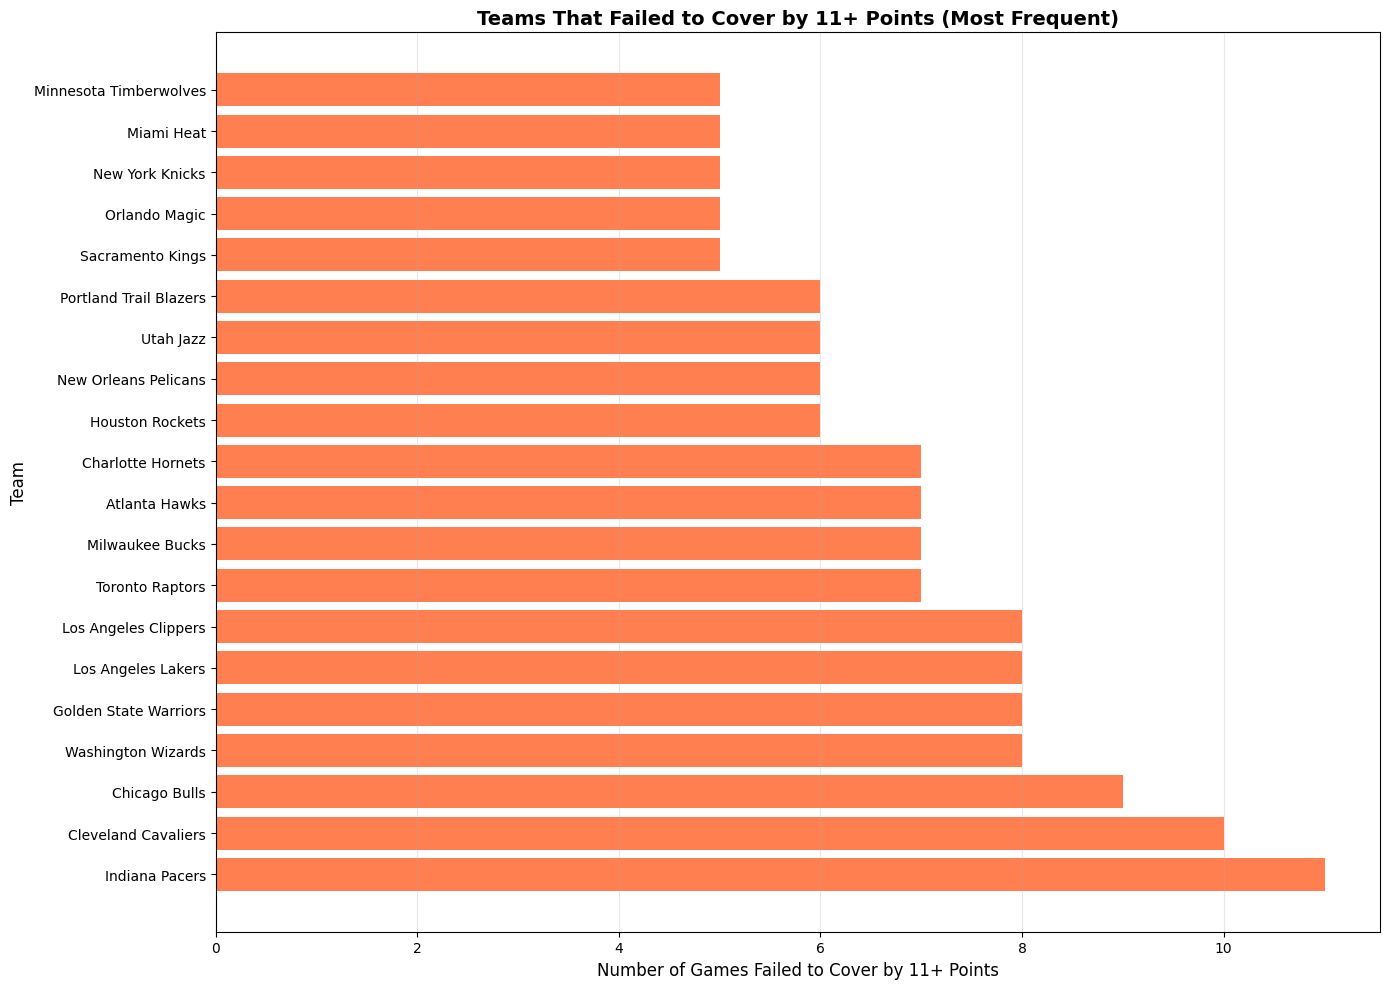


Top 10 teams that failed to cover by 11+ most often:
                    team  failed_by_11_plus_count  total_games  \
0         Indiana Pacers                       11           30   
1    Cleveland Cavaliers                       10           32   
2          Chicago Bulls                        9           29   
3     Washington Wizards                        8           28   
4  Golden State Warriors                        8           32   
5     Los Angeles Lakers                        8           29   
6   Los Angeles Clippers                        8           29   
7        Toronto Raptors                        7           31   
8        Milwaukee Bucks                        7           30   
9          Atlanta Hawks                        7           31   

   failed_by_11_plus_pct  
0                  36.67  
1                  31.25  
2                  31.03  
3                  28.57  
4                  25.00  
5                  27.59  
6                  27.59  
7  

In [69]:
# Visualize teams that fail to cover by 11+ most often
plt.figure(figsize=(14, 10))
top_teams = team_fail_11_stats.head(20)  # Show top 20
bars = plt.barh(range(len(top_teams)), top_teams['failed_by_11_plus_count'], color='coral')
plt.yticks(range(len(top_teams)), top_teams['team'])
plt.xlabel('Number of Games Failed to Cover by 11+ Points', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title('Teams That Failed to Cover by 11+ Points (Most Frequent)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 teams that failed to cover by 11+ most often:")
print(top_teams.head(10)[['team', 'failed_by_11_plus_count', 'total_games', 'failed_by_11_plus_pct']])


In [70]:
# Summary statistics
print("Summary: Failed to Cover by 11+ Points")
print("="*60)
print(f"Total occurrences: {team_df['failed_by_11_plus'].sum()}")
print(f"Percentage of all games: {team_df['failed_by_11_plus'].sum() / len(team_df) * 100:.2f}%")
print(f"\nHome team failed to cover by 11+: {team_df[team_df['was_home']]['failed_by_11_plus'].sum()}")
print(f"Away team failed to cover by 11+: {team_df[~team_df['was_home']]['failed_by_11_plus'].sum()}")
print(f"\nAverage per team: {team_fail_11_stats['failed_by_11_plus_count'].mean():.2f} games")
print(f"Median per team: {team_fail_11_stats['failed_by_11_plus_count'].median():.0f} games")
print(f"Max for any team: {team_fail_11_stats['failed_by_11_plus_count'].max()} games")
print(f"Min for any team: {team_fail_11_stats['failed_by_11_plus_count'].min()} games")
print(f"\nTeams with 0 occurrences: {(team_fail_11_stats['failed_by_11_plus_count'] == 0).sum()}")
print(f"Teams with 5+ occurrences: {(team_fail_11_stats['failed_by_11_plus_count'] >= 5).sum()}")
print(f"Teams with 10+ occurrences: {(team_fail_11_stats['failed_by_11_plus_count'] >= 10).sum()}")


Summary: Failed to Cover by 11+ Points
Total occurrences: 169
Percentage of all games: 18.78%

Home team failed to cover by 11+: 85
Away team failed to cover by 11+: 84

Average per team: 5.63 games
Median per team: 6 games
Max for any team: 11 games
Min for any team: 1 games

Teams with 0 occurrences: 0
Teams with 5+ occurrences: 20
Teams with 10+ occurrences: 2


## Dynamic Failed to Cover Analysis

Set the threshold (1-13) to analyze how often teams fail to cover by that many points or more.


In [71]:
# Set the threshold (1-13) - Change this number to analyze different thresholds
THRESHOLD = 9  # Change this to any number from 1 to 13

# Validate threshold
if THRESHOLD < 1 or THRESHOLD > 13:
    print("Error: THRESHOLD must be between 1 and 13")
else:
    print(f"Analysis for teams failing to cover by {THRESHOLD}+ points")
    print("="*60)


Analysis for teams failing to cover by 9+ points


In [72]:
# Calculate how often teams fail to cover by THRESHOLD+ points
# spread_result_difference < -THRESHOLD means they didn't cover by more than THRESHOLD points

team_df[f'failed_by_{THRESHOLD}_plus'] = team_df['spread_result_difference'] < -THRESHOLD

print(f"Failed to Cover by {THRESHOLD}+ Points Analysis:")
print("="*60)
print(f"Total team-game records: {len(team_df)}")
print(f"Games where team failed to cover by {THRESHOLD}+: {team_df[f'failed_by_{THRESHOLD}_plus'].sum()}")
print(f"Percentage: {team_df[f'failed_by_{THRESHOLD}_plus'].sum() / len(team_df) * 100:.2f}%")


Failed to Cover by 9+ Points Analysis:
Total team-game records: 900
Games where team failed to cover by 9+: 207
Percentage: 23.00%


In [73]:
# Calculate per-team statistics for failing to cover by THRESHOLD+
team_fail_stats = team_df.groupby('team').agg({
    f'failed_by_{THRESHOLD}_plus': ['sum', 'count']
}).reset_index()

team_fail_stats.columns = ['team', 'failed_count', 'total_games']
team_fail_stats['failed_pct'] = (team_fail_stats['failed_count'] / 
                                  team_fail_stats['total_games'] * 100).round(2)

# Sort by frequency
team_fail_stats = team_fail_stats.sort_values('failed_count', ascending=False).reset_index(drop=True)

print(f"Teams that Failed to Cover by {THRESHOLD}+ Points:")
print("="*60)
team_fail_stats


Teams that Failed to Cover by 9+ Points:


,team,failed_count,total_games,failed_pct
0,Cleveland Cavaliers,14,32,43.75
1,Los Angeles Clippers,13,29,44.83
2,Indiana Pacers,11,30,36.67
3,Washington Wizards,10,28,35.71
4,Chicago Bulls,10,29,34.48
5,Charlotte Hornets,9,30,30.00
6,Toronto Raptors,9,31,29.03
7,Golden State Warriors,9,32,28.12
8,Los Angeles Lakers,9,29,31.03
9,Utah Jazz,8,29,27.59


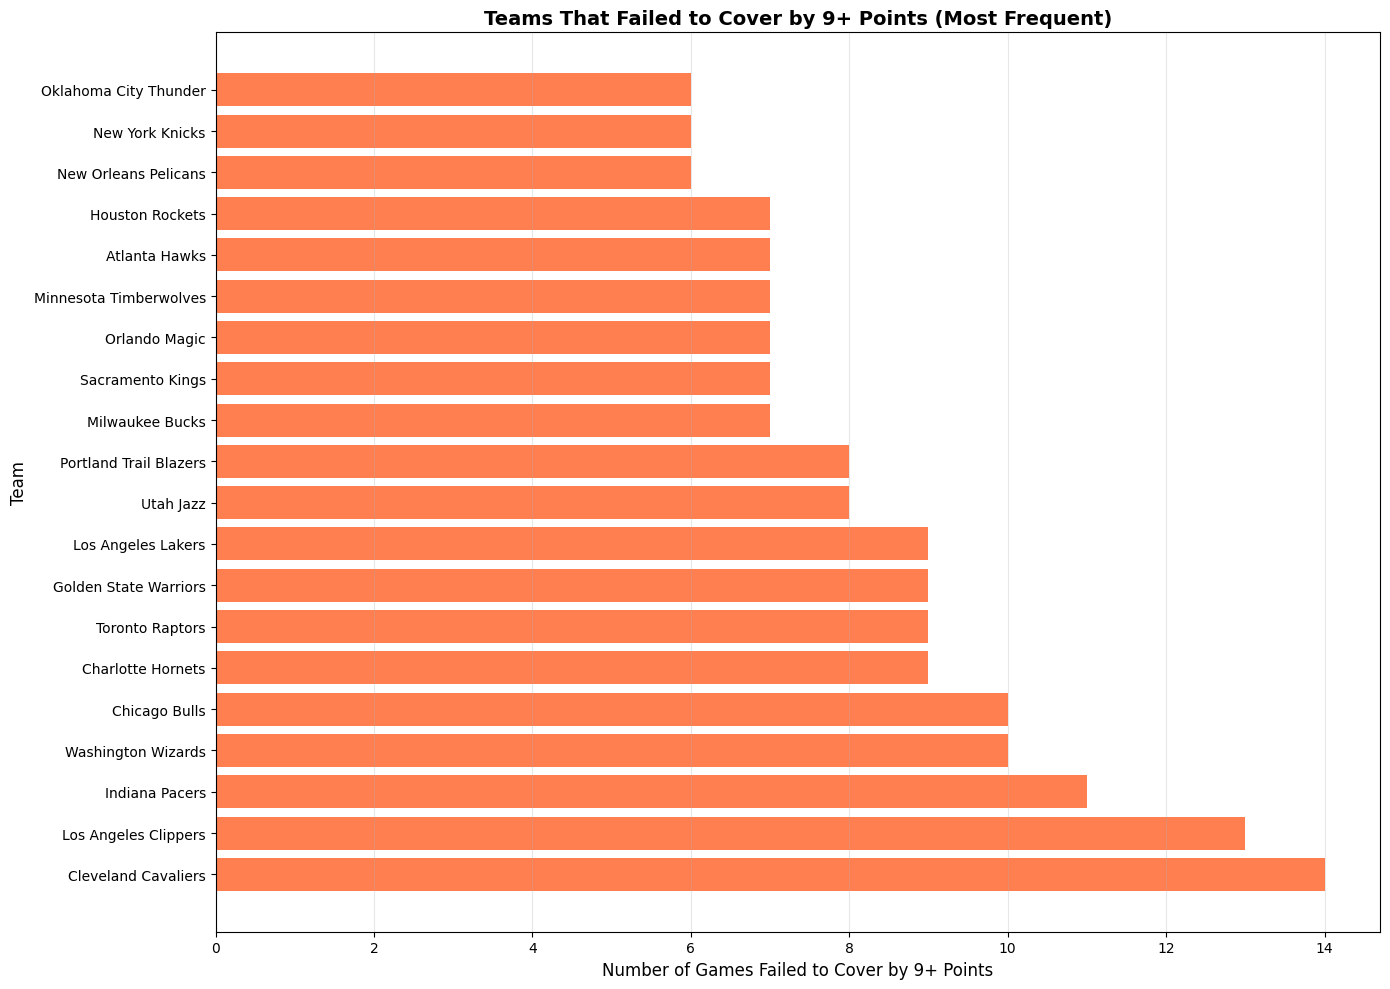


Top 10 teams that failed to cover by 9+ most often:
                    team  failed_count  total_games  failed_pct
0    Cleveland Cavaliers            14           32       43.75
1   Los Angeles Clippers            13           29       44.83
2         Indiana Pacers            11           30       36.67
3     Washington Wizards            10           28       35.71
4          Chicago Bulls            10           29       34.48
5      Charlotte Hornets             9           30       30.00
6        Toronto Raptors             9           31       29.03
7  Golden State Warriors             9           32       28.12
8     Los Angeles Lakers             9           29       31.03
9              Utah Jazz             8           29       27.59


In [74]:
# Visualize teams that fail to cover by THRESHOLD+ most often
plt.figure(figsize=(14, 10))
top_teams = team_fail_stats.head(20)  # Show top 20
bars = plt.barh(range(len(top_teams)), top_teams['failed_count'], color='coral')
plt.yticks(range(len(top_teams)), top_teams['team'])
plt.xlabel(f'Number of Games Failed to Cover by {THRESHOLD}+ Points', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.title(f'Teams That Failed to Cover by {THRESHOLD}+ Points (Most Frequent)', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 teams that failed to cover by {THRESHOLD}+ most often:")
print(top_teams.head(10)[['team', 'failed_count', 'total_games', 'failed_pct']])


In [75]:
# Summary statistics
print(f"Summary: Failed to Cover by {THRESHOLD}+ Points")
print("="*60)
print(f"Total occurrences: {team_df[f'failed_by_{THRESHOLD}_plus'].sum()}")
print(f"Percentage of all games: {team_df[f'failed_by_{THRESHOLD}_plus'].sum() / len(team_df) * 100:.2f}%")
print(f"\nHome team failed to cover by {THRESHOLD}+: {team_df[team_df['was_home']][f'failed_by_{THRESHOLD}_plus'].sum()}")
print(f"Away team failed to cover by {THRESHOLD}+: {team_df[~team_df['was_home']][f'failed_by_{THRESHOLD}_plus'].sum()}")
print(f"\nAverage per team: {team_fail_stats['failed_count'].mean():.2f} games")
print(f"Median per team: {team_fail_stats['failed_count'].median():.0f} games")
print(f"Max for any team: {team_fail_stats['failed_count'].max()} games")
print(f"Min for any team: {team_fail_stats['failed_count'].min()} games")
print(f"\nTeams with 0 occurrences: {(team_fail_stats['failed_count'] == 0).sum()}")
print(f"Teams with 5+ occurrences: {(team_fail_stats['failed_count'] >= 5).sum()}")
print(f"Teams with 10+ occurrences: {(team_fail_stats['failed_count'] >= 10).sum()}")


Summary: Failed to Cover by 9+ Points
Total occurrences: 207
Percentage of all games: 23.00%

Home team failed to cover by 9+: 100
Away team failed to cover by 9+: 107

Average per team: 6.90 games
Median per team: 7 games
Max for any team: 14 games
Min for any team: 1 games

Teams with 0 occurrences: 0
Teams with 5+ occurrences: 25
Teams with 10+ occurrences: 5


In [76]:
# Show examples of games where teams failed to cover by THRESHOLD+
failed_examples = team_df[team_df[f'failed_by_{THRESHOLD}_plus']].copy()
failed_examples = failed_examples.sort_values('spread_result_difference').reset_index(drop=True)

print(f"Examples of Games Where Teams Failed to Cover by {THRESHOLD}+ Points:")
print("="*80)
print(f"Total occurrences: {len(failed_examples)}")
print(f"\nWorst failures (most negative spread_result_difference):")
display(failed_examples[['team', 'opponent', 'game_date', 'was_home', 'spread', 
                         'score_for', 'score_against', 'spread_result_difference']].head(10))


Examples of Games Where Teams Failed to Cover by 9+ Points:
Total occurrences: 207

Worst failures (most negative spread_result_difference):


,team,opponent,game_date,was_home,spread,score_for,score_against,spread_result_difference
0,Milwaukee Bucks,Brooklyn Nets,2025-12-14,False,-1.5,82,127,-46.5
1,Chicago Bulls,Miami Heat,2025-11-21,True,-2.5,107,143,-38.5
2,Sacramento Kings,Memphis Grizzlies,2025-11-20,False,3.5,96,137,-37.5
3,Dallas Mavericks,San Antonio Spurs,2025-10-22,True,-4.5,92,125,-37.5
4,Philadelphia 76ers,Orlando Magic,2025-11-25,True,4.5,103,144,-36.5
5,Memphis Grizzlies,Miami Heat,2025-10-24,True,-3.0,114,146,-35.0
6,Washington Wizards,Boston Celtics,2025-12-04,True,10.5,101,146,-34.5
7,Phoenix Suns,Oklahoma City Thunder,2025-12-10,False,15.5,89,138,-33.5
8,Los Angeles Clippers,Utah Jazz,2025-10-22,False,-10.5,108,129,-31.5
9,Toronto Raptors,Charlotte Hornets,2025-12-05,True,-6.5,86,111,-31.5


### How to Use This Analysis

1. **Change the THRESHOLD variable** in the cell above (set it to any number from 1 to 13)
2. **Re-run all cells** from the "Dynamic Failed to Cover Analysis" section onward
3. All statistics, visualizations, and examples will update automatically based on your chosen threshold

**Example:**
- Set `THRESHOLD = 5` to see how often teams fail to cover by 5+ points
- Set `THRESHOLD = 1` to see how often teams fail to cover by 1+ points (essentially all non-covers)
- Set `THRESHOLD = 13` to see how often teams fail to cover by 13+ points


## Failed to Cover Percentage Table

Table showing the percentage of times teams failed to cover by each threshold (1-13).


In [77]:
# Calculate percentage for each threshold from 1 to 13
threshold_data = []

for threshold in range(1, 14):
    failed_count = (team_df['spread_result_difference'] < -threshold).sum()
    total_games = len(team_df)
    percentage = (failed_count / total_games * 100).round(2)
    
    # Also calculate home vs away breakdown
    home_failed = team_df[team_df['was_home']]['spread_result_difference'].apply(lambda x: x < -threshold).sum()
    away_failed = team_df[~team_df['was_home']]['spread_result_difference'].apply(lambda x: x < -threshold).sum()
    home_total = team_df['was_home'].sum()
    away_total = (~team_df['was_home']).sum()
    home_pct = (home_failed / home_total * 100).round(2) if home_total > 0 else 0
    away_pct = (away_failed / away_total * 100).round(2) if away_total > 0 else 0
    
    threshold_data.append({
        'Threshold': threshold,
        'Total Failed': failed_count,
        'Total Games': total_games,
        'Overall %': percentage,
        'Home Failed': home_failed,
        'Home %': home_pct,
        'Away Failed': away_failed,
        'Away %': away_pct
    })

threshold_df = pd.DataFrame(threshold_data)
print("Failed to Cover by Threshold - Percentage Table")
print("="*80)
threshold_df


Failed to Cover by Threshold - Percentage Table


,Threshold,Total Failed,Total Games,Overall %,Home Failed,Home %,Away Failed,Away %
0,1,421,900,46.78,209,46.44,212,47.11
1,2,391,900,43.44,196,43.56,195,43.33
2,3,366,900,40.67,181,40.22,185,41.11
3,4,337,900,37.44,167,37.11,170,37.78
4,5,305,900,33.89,152,33.78,153,34.00
5,6,280,900,31.11,141,31.33,139,30.89
6,7,263,900,29.22,130,28.89,133,29.56
7,8,227,900,25.22,113,25.11,114,25.33
8,9,207,900,23.00,100,22.22,107,23.78
9,10,189,900,21.00,92,20.44,97,21.56


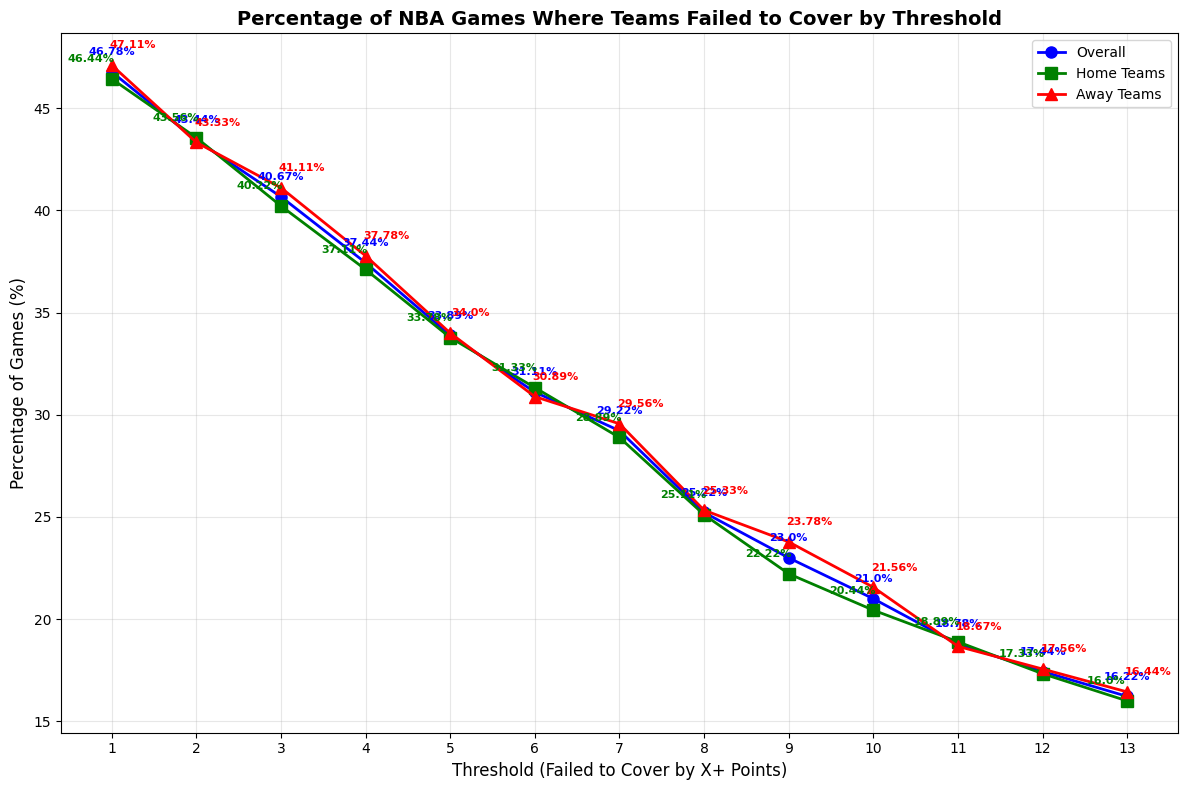

In [78]:
# Visualize the percentages
plt.figure(figsize=(12, 8))
plt.plot(threshold_df['Threshold'], threshold_df['Overall %'], marker='o', linewidth=2, markersize=8, label='Overall', color='blue')
plt.plot(threshold_df['Threshold'], threshold_df['Home %'], marker='s', linewidth=2, markersize=8, label='Home Teams', color='green')
plt.plot(threshold_df['Threshold'], threshold_df['Away %'], marker='^', linewidth=2, markersize=8, label='Away Teams', color='red')

# Add data labels to each point
for idx, row in threshold_df.iterrows():
    # Overall labels (above point)
    plt.annotate(f"{row['Overall %']}%", 
                (row['Threshold'], row['Overall %']), 
                textcoords="offset points", 
                xytext=(0,12), 
                ha='center', 
                fontsize=8, 
                color='blue',
                weight='bold')
    # Home labels (slightly to the left)
    plt.annotate(f"{row['Home %']}%", 
                (row['Threshold'], row['Home %']), 
                textcoords="offset points", 
                xytext=(-15,12), 
                ha='center', 
                fontsize=8, 
                color='green',
                weight='bold')
    # Away labels (slightly to the right)
    plt.annotate(f"{row['Away %']}%", 
                (row['Threshold'], row['Away %']), 
                textcoords="offset points", 
                xytext=(15,12), 
                ha='center', 
                fontsize=8, 
                color='red',
                weight='bold')

plt.xlabel('Threshold (Failed to Cover by X+ Points)', fontsize=12)
plt.ylabel('Percentage of Games (%)', fontsize=12)
plt.title('Percentage of NBA Games Where Teams Failed to Cover by Threshold', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 14))
plt.tight_layout()
plt.show()


In [79]:
# Display a cleaner summary table focusing on percentages
summary_table = threshold_df[['Threshold', 'Overall %', 'Home %', 'Away %']].copy()
summary_table.columns = ['Failed by X+ Points', 'Overall %', 'Home %', 'Away %']

print("Summary: Percentage of Games Where Teams Failed to Cover by Threshold")
print("="*70)
print(summary_table.to_string(index=False))


Summary: Percentage of Games Where Teams Failed to Cover by Threshold
 Failed by X+ Points  Overall %  Home %  Away %
                   1      46.78   46.44   47.11
                   2      43.44   43.56   43.33
                   3      40.67   40.22   41.11
                   4      37.44   37.11   37.78
                   5      33.89   33.78   34.00
                   6      31.11   31.33   30.89
                   7      29.22   28.89   29.56
                   8      25.22   25.11   25.33
                   9      23.00   22.22   23.78
                  10      21.00   20.44   21.56
                  11      18.78   18.89   18.67
                  12      17.44   17.33   17.56
                  13      16.22   16.00   16.44


## Cumulative Failed to Cover Analysis Over Time

Visualize how the "Percentage of NBA Games Where Teams Failed to Cover by Threshold" changes as the season progresses (cumulative from day 1, day 1+2, day 1+2+3, etc.).


In [80]:
# Ensure team_df is sorted by game_date
team_df_sorted = team_df.sort_values('game_date').copy()
team_df_sorted['game_date'] = pd.to_datetime(team_df_sorted['game_date'])

# Get unique dates in order
unique_dates = team_df_sorted['game_date'].unique()
unique_dates = sorted(unique_dates)

print(f"Season spans from {unique_dates[0].date()} to {unique_dates[-1].date()}")
print(f"Total unique game dates: {len(unique_dates)}")
print(f"\nFirst 5 dates: {[d.date() for d in unique_dates[:5]]}")
print(f"Last 5 dates: {[d.date() for d in unique_dates[-5:]]}")


Season spans from 2025-10-21 to 2025-12-25
Total unique game dates: 64

First 5 dates: [datetime.date(2025, 10, 21), datetime.date(2025, 10, 22), datetime.date(2025, 10, 23), datetime.date(2025, 10, 24), datetime.date(2025, 10, 25)]
Last 5 dates: [datetime.date(2025, 12, 20), datetime.date(2025, 12, 21), datetime.date(2025, 12, 22), datetime.date(2025, 12, 23), datetime.date(2025, 12, 25)]


In [81]:
# Calculate cumulative percentages for each threshold over time
# Separate calculations for home teams and away teams
cumulative_data = []

# For each date, calculate cumulative stats up to that date
for date_idx, current_date in enumerate(unique_dates):
    # Get all games up to and including current_date (cumulative)
    cumulative_games = team_df_sorted[team_df_sorted['game_date'] <= current_date]
    
    # Separate home and away games
    home_games = cumulative_games[cumulative_games['was_home'] == True]
    away_games = cumulative_games[cumulative_games['was_home'] == False]
    
    total_games = len(cumulative_games)
    home_total = len(home_games)
    away_total = len(away_games)
    
    if total_games > 0:
        # Calculate percentage for each threshold (1-13)
        for threshold in range(1, 14):
            # Overall
            failed_count = (cumulative_games['spread_result_difference'] < -threshold).sum()
            percentage = (failed_count / total_games * 100).round(2)
            
            # Home teams
            home_failed = (home_games['spread_result_difference'] < -threshold).sum()
            home_percentage = (home_failed / home_total * 100).round(2) if home_total > 0 else 0
            
            # Away teams
            away_failed = (away_games['spread_result_difference'] < -threshold).sum()
            away_percentage = (away_failed / away_total * 100).round(2) if away_total > 0 else 0
            
            cumulative_data.append({
                'date': current_date,
                'days_into_season': date_idx + 1,
                'threshold': threshold,
                'team_type': 'Overall',
                'failed_count': failed_count,
                'total_games': total_games,
                'percentage': percentage
            })
            
            cumulative_data.append({
                'date': current_date,
                'days_into_season': date_idx + 1,
                'threshold': threshold,
                'team_type': 'Home',
                'failed_count': home_failed,
                'total_games': home_total,
                'percentage': home_percentage
            })
            
            cumulative_data.append({
                'date': current_date,
                'days_into_season': date_idx + 1,
                'threshold': threshold,
                'team_type': 'Away',
                'failed_count': away_failed,
                'total_games': away_total,
                'percentage': away_percentage
            })

cumulative_df = pd.DataFrame(cumulative_data)
print(f"Calculated cumulative statistics for {len(unique_dates)} dates and 13 thresholds")
print(f"Separated by: Overall, Home, and Away teams")
print(f"Total data points: {len(cumulative_df)}")
cumulative_df.head(20)


Calculated cumulative statistics for 64 dates and 13 thresholds
Separated by: Overall, Home, and Away teams
Total data points: 2496


,date,days_into_season,threshold,team_type,failed_count,total_games,percentage
0,2025-10-21,1,1,Overall,2,4,50.0
1,2025-10-21,1,1,Home,2,2,100.0
2,2025-10-21,1,1,Away,0,2,0.0
3,2025-10-21,1,2,Overall,2,4,50.0
4,2025-10-21,1,2,Home,2,2,100.0
5,2025-10-21,1,2,Away,0,2,0.0
6,2025-10-21,1,3,Overall,2,4,50.0
7,2025-10-21,1,3,Home,2,2,100.0
8,2025-10-21,1,3,Away,0,2,0.0
9,2025-10-21,1,4,Overall,2,4,50.0


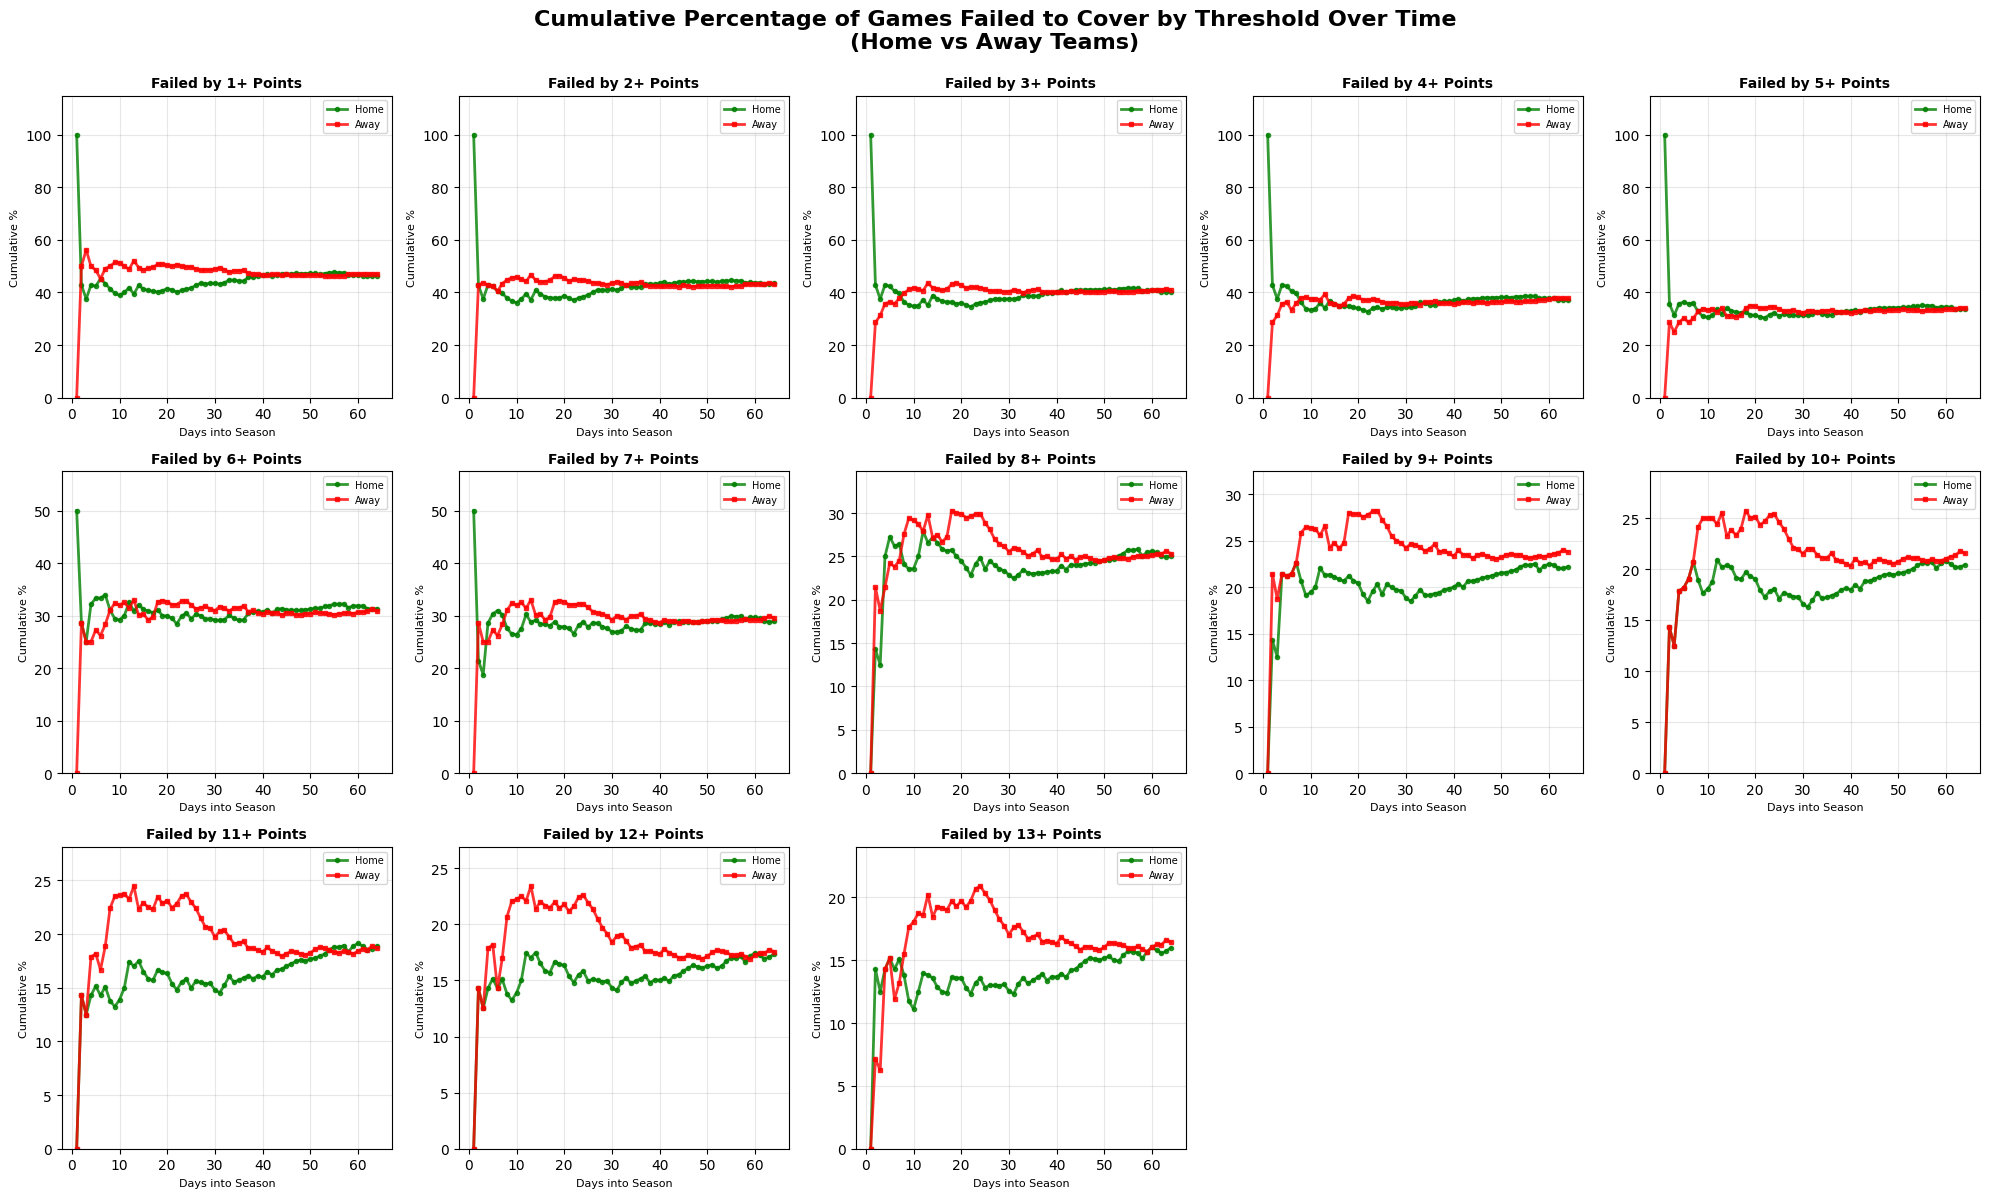

In [82]:
# Create visualization showing how percentages change over time for each threshold
# Separate lines for Home and Away teams
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with subplots - one for each threshold
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.flatten()

# Plot each threshold (1-13)
for threshold in range(1, 14):
    ax = axes[threshold - 1]
    
    # Get data for this threshold - Home teams
    home_data = cumulative_df[(cumulative_df['threshold'] == threshold) & 
                              (cumulative_df['team_type'] == 'Home')].copy()
    home_data = home_data.sort_values('date')
    
    # Get data for this threshold - Away teams
    away_data = cumulative_df[(cumulative_df['threshold'] == threshold) & 
                              (cumulative_df['team_type'] == 'Away')].copy()
    away_data = away_data.sort_values('date')
    
    # Plot Home teams
    if len(home_data) > 0:
        ax.plot(home_data['days_into_season'], home_data['percentage'], 
                linewidth=2, marker='o', markersize=3, color='green', 
                label='Home', alpha=0.8)
    
    # Plot Away teams
    if len(away_data) > 0:
        ax.plot(away_data['days_into_season'], away_data['percentage'], 
                linewidth=2, marker='s', markersize=3, color='red', 
                label='Away', alpha=0.8)
    
    ax.set_title(f'Failed by {threshold}+ Points', fontsize=10, fontweight='bold')
    ax.set_xlabel('Days into Season', fontsize=8)
    ax.set_ylabel('Cumulative %', fontsize=8)
    ax.legend(fontsize=7, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Set y-axis limits based on both datasets
    max_pct = max(
        home_data['percentage'].max() if len(home_data) > 0 else 0,
        away_data['percentage'].max() if len(away_data) > 0 else 0
    )
    ax.set_ylim([0, max_pct * 1.15 if max_pct > 0 else 50])

# Hide the 14th and 15th subplots (we only have 13 thresholds)
axes[13].axis('off')
axes[14].axis('off')

plt.suptitle('Cumulative Percentage of Games Failed to Cover by Threshold Over Time\n(Home vs Away Teams)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


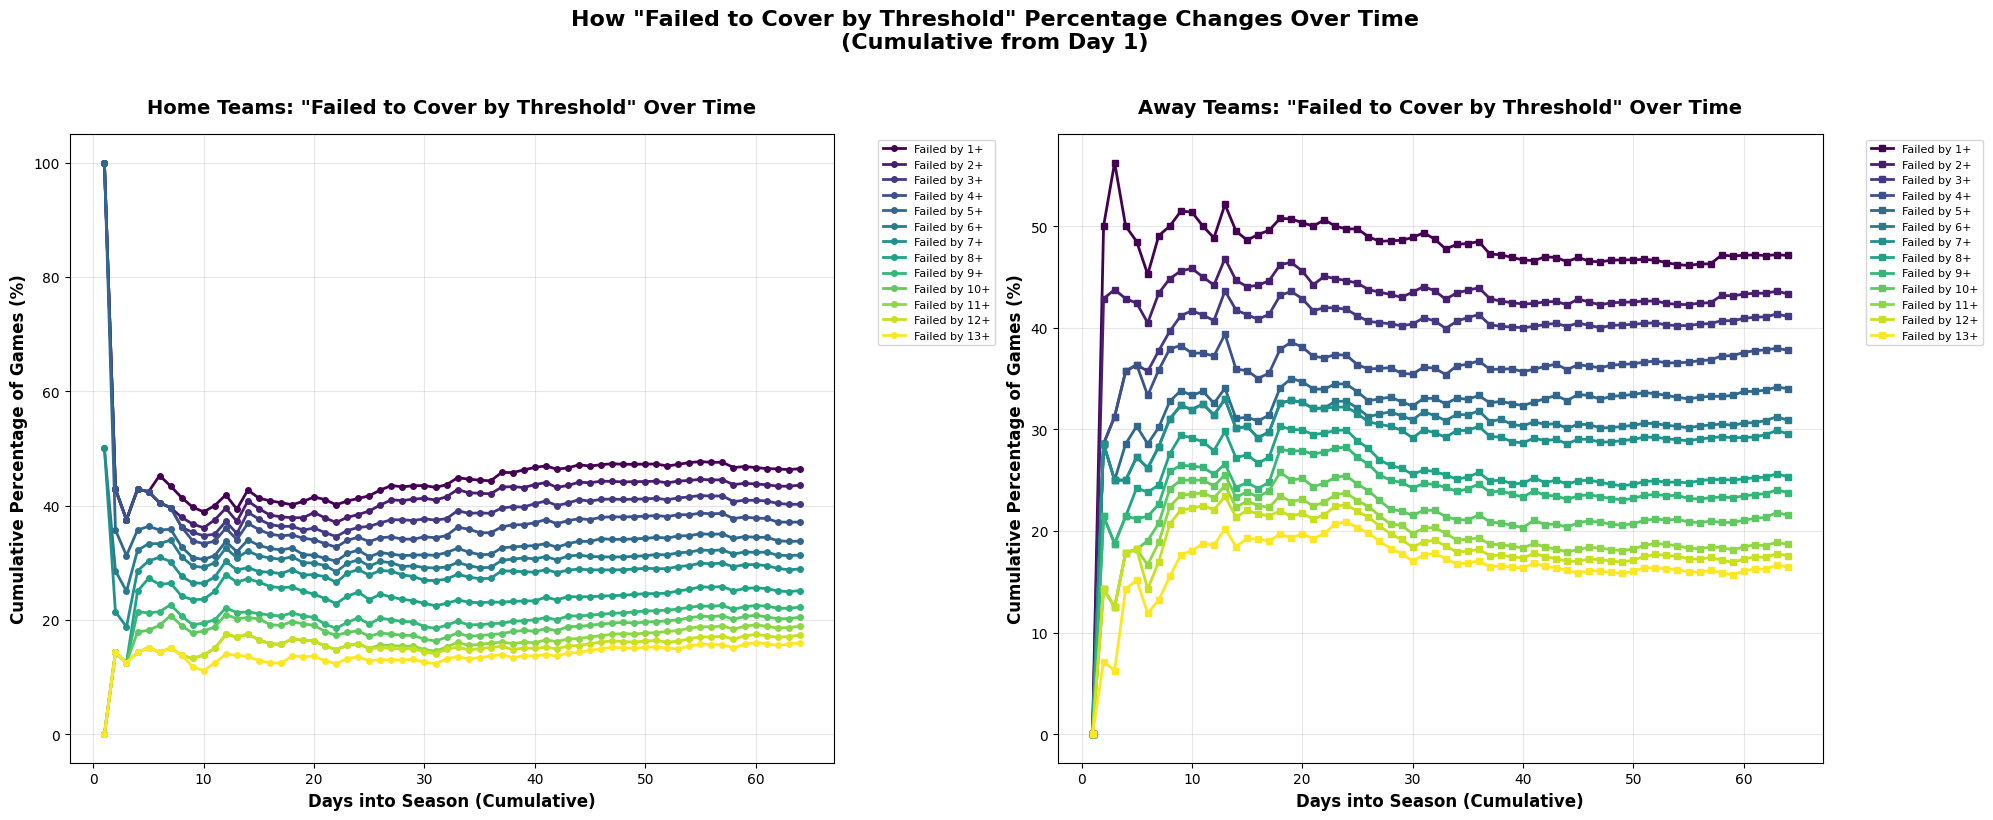

These charts show how the percentage evolves as more games are included:
- Day 1: Only games from the first day
- Day 2: Games from days 1-2
- Day 3: Games from days 1-3
- And so on...


In [83]:
# Create a combined line chart showing all thresholds on one plot
# Separate charts for Home and Away teams
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Define colors for different thresholds (use a colormap)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

# Plot Home teams
for threshold in range(1, 14):
    home_data = cumulative_df[(cumulative_df['threshold'] == threshold) & 
                              (cumulative_df['team_type'] == 'Home')].copy()
    home_data = home_data.sort_values('date')
    
    ax1.plot(home_data['days_into_season'], home_data['percentage'], 
            linewidth=2, marker='o', markersize=4, 
            label=f'Failed by {threshold}+', color=colors[threshold-1])

ax1.set_xlabel('Days into Season (Cumulative)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Percentage of Games (%)', fontsize=12, fontweight='bold')
ax1.set_title('Home Teams: "Failed to Cover by Threshold" Over Time', 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
ax1.grid(True, alpha=0.3)

# Plot Away teams
for threshold in range(1, 14):
    away_data = cumulative_df[(cumulative_df['threshold'] == threshold) & 
                              (cumulative_df['team_type'] == 'Away')].copy()
    away_data = away_data.sort_values('date')
    
    ax2.plot(away_data['days_into_season'], away_data['percentage'], 
            linewidth=2, marker='s', markersize=4, 
            label=f'Failed by {threshold}+', color=colors[threshold-1])

ax2.set_xlabel('Days into Season (Cumulative)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Percentage of Games (%)', fontsize=12, fontweight='bold')
ax2.set_title('Away Teams: "Failed to Cover by Threshold" Over Time', 
             fontsize=14, fontweight='bold', pad=15)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, ncol=1)
ax2.grid(True, alpha=0.3)

plt.suptitle('How "Failed to Cover by Threshold" Percentage Changes Over Time\n(Cumulative from Day 1)', 
         fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("These charts show how the percentage evolves as more games are included:")
print("- Day 1: Only games from the first day")
print("- Day 2: Games from days 1-2")
print("- Day 3: Games from days 1-3")
print("- And so on...")


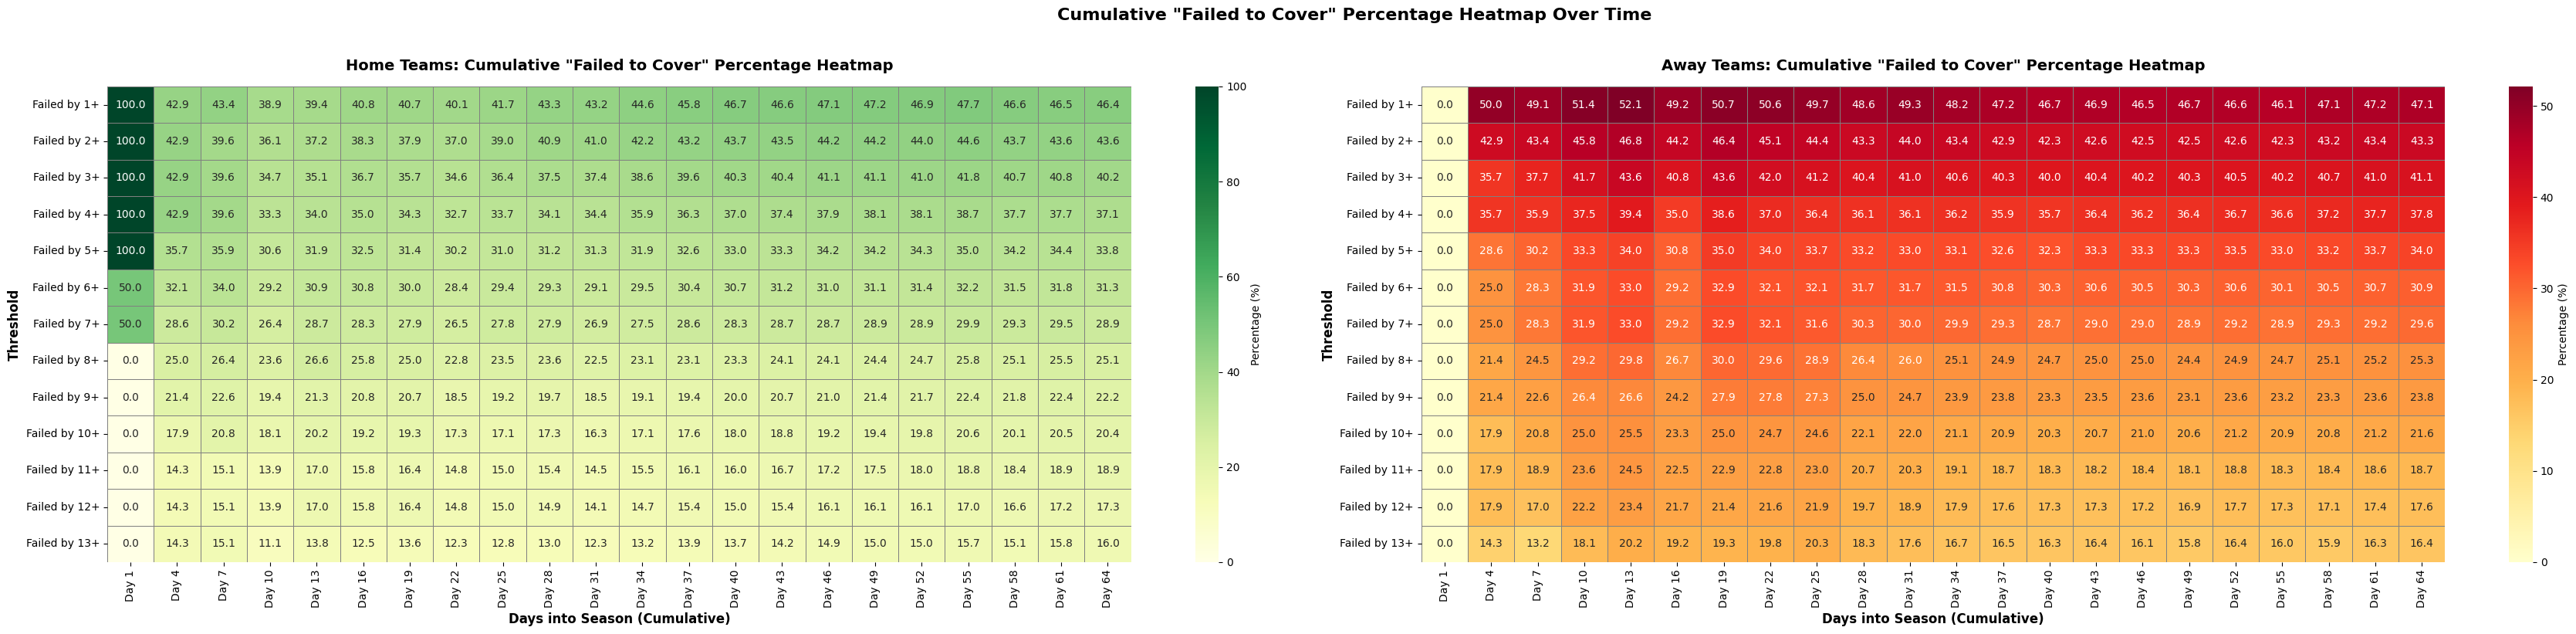

In [84]:
# Create heatmaps showing the percentage at different points in the season
# Separate heatmaps for Home and Away teams
sample_dates = unique_dates[::max(1, len(unique_dates)//20)]  # Sample ~20 dates
if unique_dates[-1] not in sample_dates:
    sample_dates = list(sample_dates) + [unique_dates[-1]]

# Create matrix for Home teams heatmap
home_heatmap_data = []
for threshold in range(1, 14):
    row = []
    for date in sample_dates:
        data_point = cumulative_df[
            (cumulative_df['threshold'] == threshold) & 
            (cumulative_df['date'] == date) &
            (cumulative_df['team_type'] == 'Home')
        ]
        if len(data_point) > 0:
            row.append(data_point.iloc[0]['percentage'])
        else:
            row.append(0)
    home_heatmap_data.append(row)

home_heatmap_df = pd.DataFrame(home_heatmap_data, 
                          index=[f'Failed by {t}+' for t in range(1, 14)],
                          columns=[f'Day {unique_dates.index(d)+1}' for d in sample_dates])

# Create matrix for Away teams heatmap
away_heatmap_data = []
for threshold in range(1, 14):
    row = []
    for date in sample_dates:
        data_point = cumulative_df[
            (cumulative_df['threshold'] == threshold) & 
            (cumulative_df['date'] == date) &
            (cumulative_df['team_type'] == 'Away')
        ]
        if len(data_point) > 0:
            row.append(data_point.iloc[0]['percentage'])
        else:
            row.append(0)
    away_heatmap_data.append(row)

away_heatmap_df = pd.DataFrame(away_heatmap_data, 
                          index=[f'Failed by {t}+' for t in range(1, 14)],
                          columns=[f'Day {unique_dates.index(d)+1}' for d in sample_dates])

# Create side-by-side heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(max(24, len(sample_dates)*1.6), 8))

# Home teams heatmap
sns.heatmap(home_heatmap_df, annot=True, fmt='.1f', cmap='YlGn', 
            cbar_kws={'label': 'Percentage (%)'}, 
            linewidths=0.5, linecolor='gray', ax=ax1)
ax1.set_xlabel('Days into Season (Cumulative)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Threshold', fontsize=12, fontweight='bold')
ax1.set_title('Home Teams: Cumulative "Failed to Cover" Percentage Heatmap', 
         fontsize=14, fontweight='bold', pad=15)

# Away teams heatmap
sns.heatmap(away_heatmap_df, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage (%)'}, 
            linewidths=0.5, linecolor='gray', ax=ax2)
ax2.set_xlabel('Days into Season (Cumulative)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Threshold', fontsize=12, fontweight='bold')
ax2.set_title('Away Teams: Cumulative "Failed to Cover" Percentage Heatmap', 
         fontsize=14, fontweight='bold', pad=15)

plt.suptitle('Cumulative "Failed to Cover" Percentage Heatmap Over Time', 
         fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [85]:
# Show a comparison table: percentage at start vs end of season
# Separate tables for Home and Away teams
comparison_data = []

for threshold in range(1, 14):
    # First date (day 1)
    first_date = unique_dates[0]
    
    # Home teams - Day 1
    home_first = cumulative_df[
        (cumulative_df['threshold'] == threshold) & 
        (cumulative_df['date'] == first_date) &
        (cumulative_df['team_type'] == 'Home')
    ]
    home_first_pct = home_first.iloc[0]['percentage'] if len(home_first) > 0 else 0
    home_first_games = home_first.iloc[0]['total_games'] if len(home_first) > 0 else 0
    
    # Away teams - Day 1
    away_first = cumulative_df[
        (cumulative_df['threshold'] == threshold) & 
        (cumulative_df['date'] == first_date) &
        (cumulative_df['team_type'] == 'Away')
    ]
    away_first_pct = away_first.iloc[0]['percentage'] if len(away_first) > 0 else 0
    away_first_games = away_first.iloc[0]['total_games'] if len(away_first) > 0 else 0
    
    # Last date (current)
    last_date = unique_dates[-1]
    
    # Home teams - Final
    home_last = cumulative_df[
        (cumulative_df['threshold'] == threshold) & 
        (cumulative_df['date'] == last_date) &
        (cumulative_df['team_type'] == 'Home')
    ]
    home_last_pct = home_last.iloc[0]['percentage'] if len(home_last) > 0 else 0
    home_last_games = home_last.iloc[0]['total_games'] if len(home_last) > 0 else 0
    
    # Away teams - Final
    away_last = cumulative_df[
        (cumulative_df['threshold'] == threshold) & 
        (cumulative_df['date'] == last_date) &
        (cumulative_df['team_type'] == 'Away')
    ]
    away_last_pct = away_last.iloc[0]['percentage'] if len(away_last) > 0 else 0
    away_last_games = away_last.iloc[0]['total_games'] if len(away_last) > 0 else 0
    
    home_change = home_last_pct - home_first_pct
    away_change = away_last_pct - away_first_pct
    
    comparison_data.append({
        'Threshold': f'Failed by {threshold}+',
        'Home Day 1 %': home_first_pct,
        'Home Day 1 Games': home_first_games,
        'Home Final %': home_last_pct,
        'Home Final Games': home_last_games,
        'Home Change': f"{home_change:+.2f}%",
        'Away Day 1 %': away_first_pct,
        'Away Day 1 Games': away_first_games,
        'Away Final %': away_last_pct,
        'Away Final Games': away_last_games,
        'Away Change': f"{away_change:+.2f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print("Comparison: Percentage at Start vs End of Season (Home vs Away Teams)")
print("="*120)
print(comparison_df.to_string(index=False))


Comparison: Percentage at Start vs End of Season (Home vs Away Teams)
    Threshold  Home Day 1 %  Home Day 1 Games  Home Final %  Home Final Games Home Change  Away Day 1 %  Away Day 1 Games  Away Final %  Away Final Games Away Change
 Failed by 1+         100.0                 2         46.44               450     -53.56%           0.0                 2         47.11               450     +47.11%
 Failed by 2+         100.0                 2         43.56               450     -56.44%           0.0                 2         43.33               450     +43.33%
 Failed by 3+         100.0                 2         40.22               450     -59.78%           0.0                 2         41.11               450     +41.11%
 Failed by 4+         100.0                 2         37.11               450     -62.89%           0.0                 2         37.78               450     +37.78%
 Failed by 5+         100.0                 2         33.78               450     -66.22%           